# Bifurcation data analysis

In this notebook, let's create a workflow to process images from the **bifurcation** experiment. This will involve 3 steps:

- crop channel regions from raw images
- apply PIV on cropped images
- compute relevant numbers, e.g. flow rates in each channel, from PIV data 

## 1 Crop channel regions from raw images

In a typical bifurcation experiment, we have a 3-way micro-channel photoprinted on a resin. This micro-channel is cast on the active microtubule system at an oil-water interface. The chaotic turbulent-like motions of microtubules will be rectified by the micro-channels. Ratchet structures are used to set one of the channels as inlet. The flow then goes into either remaining channels, or into both at certain fractions. We study what is the "preferred" bifurcation of the flow. 

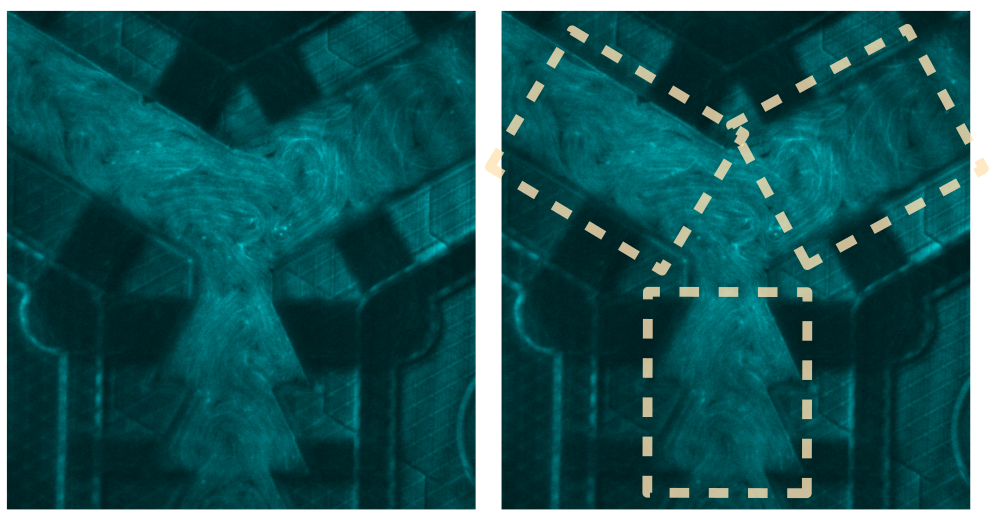

The above image (left) is an example microscopic view under a microscope. The bottom channel is modified with ratchet structures, and is therefore the inlet. The two branches on the top are the test channels. We want to measure the flow rate in the 3 channels separately. It's convenient to crop rectangular regions containing each branch, as shown in the right panel above. And then rotate the region to horizontal or vertical direction, so that the velocity along the channel direction is just the horizontal or vertical component of the measured velocity. 

In the following, let's write the code to crop the images. 

In [22]:
from skimage import io
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils import rotate
from matplotlib.patches import Rectangle
from myImageLib import readdata, bestcolor
import os
from pivLib import PIV, PIV_masked, read_piv
from IPython.display import clear_output
from corrLib import divide_windows

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


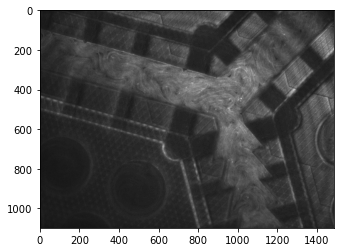

In [3]:
img = io.imread(r"test_files/crop-test.tif")

plt.imshow(img, cmap="gray")

The first step is to rotate the image, so that each channel have their +1 flow direction going up. This requires the knowledge of 3 rotation angle and 3 crop region coordinates after respective rotations. We start by mannually provide these numbers. <font color="red">Later on, we will develop more intelligent algorithm that crops the image more automatically.</font>

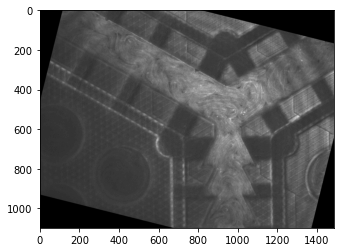

In [4]:
imgr = rotate(img, angle=-14)
plt.imshow(imgr, cmap="gray")

From ImageJ, we manually get 3 sets of (rotation angle, crop rectangle), saved in the "crop-data.csv" file as a table (picture below). Here, important information is the angle in odd lines and (BX, BY, Width, Height) in even lines. For example, to get the first crop of the inlet ratchet channel, we first rotate the raw image (angle[1]-90) degrees. Then, crop the resulting image using the rectangle cornered at (X, Y) with width and height (Width, Height) in the second line (2). 

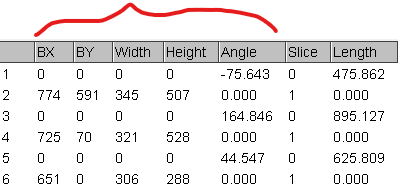

In [5]:
# load crop data from file
crop_data = pd.read_csv(r"test_files/crop-data.csv")
crop_data.head()

,,BX,BY,Width,Height,Angle,Slice,Length
0,1,0,0,0,0,104.357,0,475.862
1,2,774,591,345,507,0.000,1,0.000
2,3,0,0,0,0,164.846,0,895.127
3,4,725,70,321,528,0.000,1,0.000
4,5,0,0,0,0,44.547,0,625.809


In [6]:
# convert to angle, xy, wh
angle = 90 - crop_data.at[0, "Angle"]
x, y, w, h = crop_data.at[1, "BX"], crop_data.at[1, "BY"], crop_data.at[1, "Width"], crop_data.at[1, "Height"]

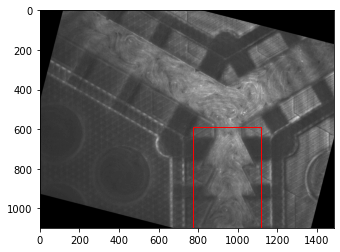

In [7]:
# show rotated image and crop region
imgr = rotate(img, angle=angle)
crop = imgr[y:y+h, x:x+w]
fig, ax = plt.subplots()
ax.imshow(imgr, cmap="gray")
rect = Rectangle((x, y), w, h, fill=False, ec="red")
ax.add_patch(rect)

Now, we write a function to preview all the crops. In this specific channel design, we will generate 3 crops from a single image. However, the function here should be compatible with arbitrary numbers of crops. 

In [8]:
def preview_crop(img, crop_data):
    """Preview the channel crops.
    Args:
    img -- raw image
    crop_data -- rotation angle and rectangle descriptor, generate manually from ImageJ
    """
    ncrops = len(crop_data) // 2
    img_in_row = 3
    nrows = ncrops // 3 + 1
    fig = plt.figure(figsize=(6, 2*nrows))
    
    for i in range(0, ncrops):
        angle = 90 - crop_data.at[2*i, "Angle"]
        x, y, w, h = crop_data.at[2*i+1, "BX"], crop_data.at[2*i+1, "BY"], crop_data.at[2*i+1, "Width"], crop_data.at[2*i+1, "Height"]
        imgr = rotate(img, angle=angle)
        crop = imgr[y:y+h, x:x+w]
        ax = fig.add_subplot(nrows, img_in_row, i+1)
        ax.imshow(crop, cmap="gray")

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


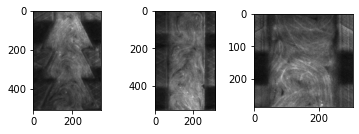

In [9]:
img = io.imread(r"test_files/crop-test.tif")
crop_data = pd.read_csv(r"test_files/crop-data.csv")
preview_crop(img, crop_data)

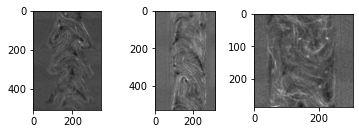

In [14]:
# preview real data
img = io.imread(r"E:/AN/10172022/05/remove-background/00000.tif")
crop_data = pd.read_csv(r"test_files/crop-data.csv")
preview_crop(img, crop_data)

Next, we write a function to crop an image sequence, using the same crop-data.

In [11]:
def crop_sequence(sequence, crop_data, save_folder):
    """Crop an image sequence and save the resulting crops into respective folder.
    Crop folders will be named 0, 1, 2 ...
    Args:
    sequence -- return value of readdata
    crop_data -- manually generated ImageJ rotation and crop data
    save_folder -- master folder to save cropped images"""
    ncrops = len(crop_data) // 2
    crop_folder = {}
    for i in range(ncrops):
        crop_folder[i] = os.path.join(save_folder, "crop-{:d}".format(i))
        if os.path.exists(crop_folder[i]) == False:
            os.makedirs(crop_folder[i])
    for num, item in sequence.iterrows():
        img = io.imread(item.Dir)
        name = item.Name
        for i in range(0, ncrops):
            angle = 90 - crop_data.at[2*i, "Angle"]
            x, y, w, h = crop_data.at[2*i+1, "BX"], crop_data.at[2*i+1, "BY"], crop_data.at[2*i+1, "Width"], crop_data.at[2*i+1, "Height"]
            imgr = rotate(img, angle=angle)
            crop = imgr[y:y+h, x:x+w]
            io.imsave(os.path.join(crop_folder[i], "{}.tif".format(name)), crop, check_contrast=False)

In [12]:
seq = readdata("test_files", "tif")
crop_data = pd.read_csv(r"test_files/crop-data.csv")
save_folder = r"test_files/cropped_images"
crop_sequence(seq, crop_data, save_folder)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
D:\miniconda\envs\py39\lib\site-packages\tifffile\tifffile.py:1570: UserWarning: TiffWriter: writing zero size array to nonconformant TIFF
  warnings.warn(


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\imgwarp.cpp:2595: error: (-215:Assertion failed) src.cols > 0 && src.rows > 0 in function 'cv::warpAffine'


### 1.1 Batch crop

In [67]:
# external disk test
folder = r"E:\AN\10172022"
for n in range(4, 19):
    seq = readdata(os.path.join(folder, "{:02d}".format(n), "remove-background"), "tif")
    crop_data = pd.read_csv(r"test_files/crop-data.csv")
    save_folder = os.path.join(folder, "channel_crops_rb", "{:02d}".format(n))
    if os.path.exists(save_folder) == False:
        crop_sequence(seq, crop_data, save_folder)

## 2 Flow rate analysis

### 2.1 PIV

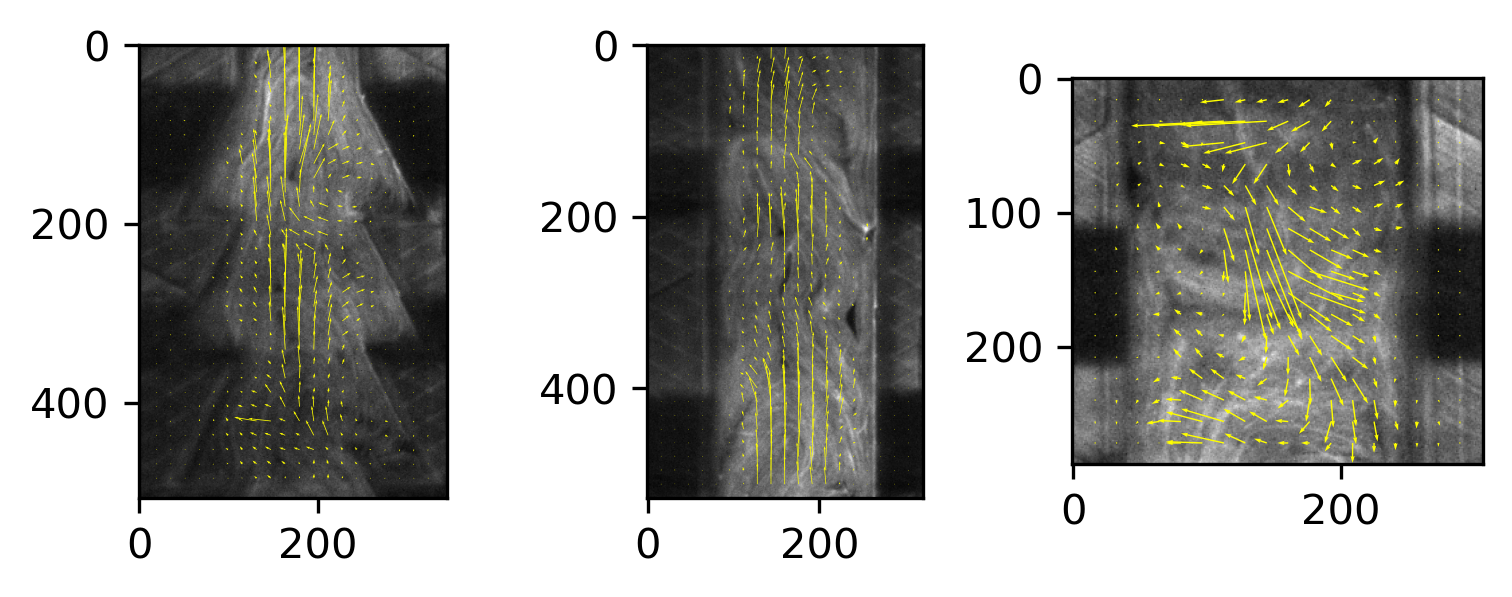

In [121]:
folder = r"E:\AN\10172022"
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6, 2), dpi=300)
for i in range(3):
    I0 = io.imread(os.path.join(folder, "channel_crops_rb", "04", "crop-{:d}".format(i), "00000.tif"))
    I1 = io.imread(os.path.join(folder, "channel_crops_rb", "04", "crop-{:d}".format(i), "00001.tif"))
    x, y, u, v = PIV(I0, I1, 32, 16, 1)
    ax[i].imshow(I0, cmap="gray")
    ax[i].quiver(x, y, u, v, color="yellow")

### 2.2 Masked PIV

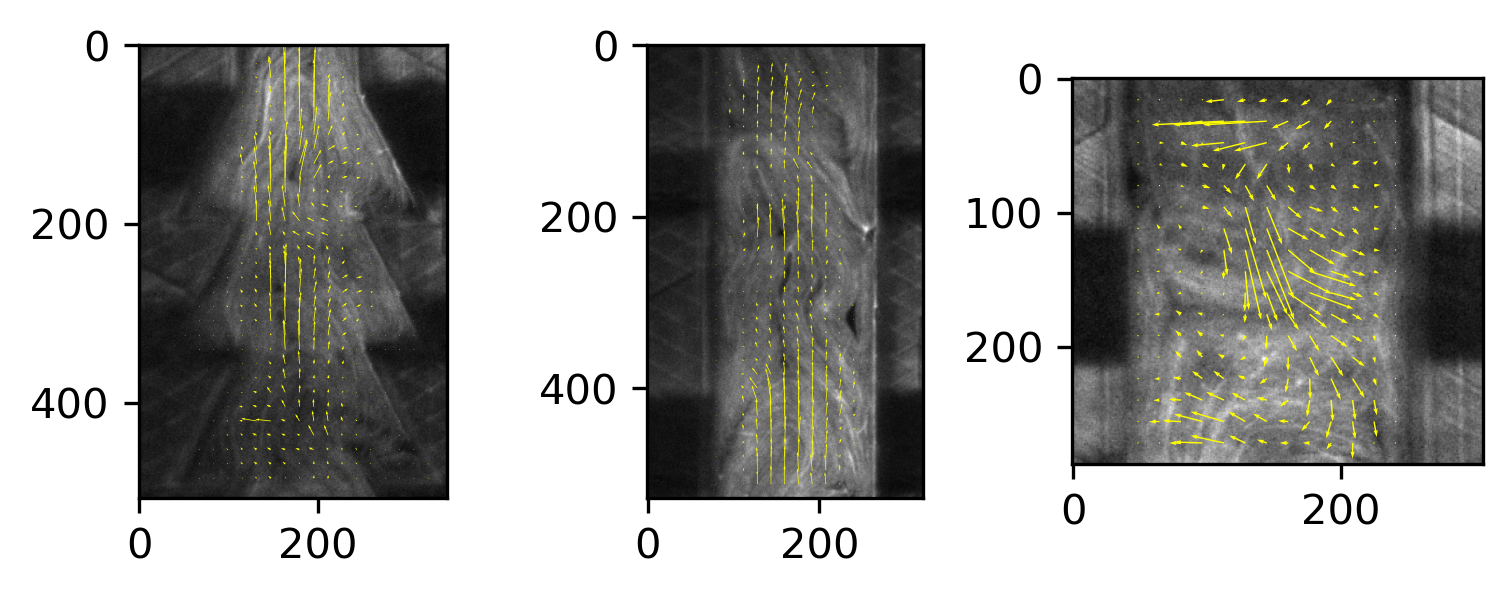

In [53]:
folder = r"E:\AN\10172022"
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6, 2), dpi=300)
for i in range(3):
    I0 = io.imread(os.path.join(folder, "channel_crops", "04", "crop-{:d}".format(i), "00000.tif"))
    I1 = io.imread(os.path.join(folder, "channel_crops", "04", "crop-{:d}".format(i), "00001.tif"))
    mask = io.imread(os.path.join(folder, "channel_crops", "04", "masks", "crop-{:d}.tif".format(i)))
    x, y, u, v = PIV_masked(I0, I1, 32, 16, 1, mask)
    ax[i].imshow(I0, cmap="gray")
    ax[i].quiver(x, y, u, v, color="yellow")

**Batch PIV**

In [68]:
sfL = ["crop-0", "crop-1", "crop-2"]
crop_folder = r"E:\AN\10172022\channel_crops_rb"
piv_folder = r"E:\AN\10172022\channel_piv_rb"
n = 4
winsize = 32
overlap = 16
dt = 1
for n in range(4, 19):
    for sf in sfL:
        img_folder = os.path.join(crop_folder, "{:02d}".format(n), sf)
        save_folder = os.path.join(piv_folder, "{:02d}".format(n), sf)
        if os.path.exists(save_folder) == False:
            os.makedirs(save_folder)
        l = readdata(img_folder, "tif")
        for i0, i1 in zip(l.index[::2], l.index[1::2]):
            I0 = io.imread(l.at[i0, "Dir"])
            I1 = io.imread(l.at[i1, "Dir"])
            x, y, u, v = PIV(I0, I1, winsize, overlap, dt)
            pivData = pd.DataFrame({"x": x.flatten(), "y": y.flatten(), "u": u.flatten(), "v": v.flatten()})
            pivData.to_csv(os.path.join(save_folder, "{0}-{1}.csv".format(l.at[i0, "Name"], l.at[i1, "Name"])), index=False)

In [69]:
# check PIV results
n = 5
limg = readdata(os.path.join(crop_folder, "{:02d}".format(n), "crop-0"), "tif")
lpiv = readdata(os.path.join(piv_folder, "{:02d}".format(n), "crop-0"), "csv")
for i in range(len(lpiv)):
    img = io.imread(limg.at[i*2, "Dir"])
    x, y, u, v = read_piv(lpiv.at[i, "Dir"])
    plt.imshow(img, cmap="gray")
    plt.quiver(x, y, u, v, color="yellow")
    plt.pause(0.1)
    clear_output(wait=True)

KeyboardInterrupt: 

**Apply mask**

In [70]:
piv_folder = r"E:\AN\10172022\channel_piv_rb"
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"
sfL = ["crop-0", "crop-1", "crop-2"]
for n in range(5, 6):
    for sf in sfL:
        mask_raw = io.imread(os.path.join(mask_folder, "{}.tif".format(sf)))
        X, Y, mask = divide_windows(mask_raw, [32, 32], 16)
        mask_bool = mask >= mask.max()
        l = readdata(os.path.join(piv_folder, "{:02d}".format(n), sf), "csv")
        for num, i in l.iterrows():
            x, y, u, v = read_piv(i.Dir)
            u[~mask_bool] = np.nan
            v[~mask_bool] = np.nan
            pivData = pd.DataFrame({"x": x.flatten(), "y": y.flatten(), "u": u.flatten(), "v": v.flatten()})
            pivData.to_csv(i.Dir, index=False)

### 2.3 Velocity field to flow rate

We assume the active nematics system is imcompressible and use volumetric flow rate $Q$ as the flow rate that should be conserved at each point in the channel. 

In each of the cropped channel region, we know from the videos that the primary flow direction is along the channel directions, either being positive or negative. Therefore, we only extract flow in these directions, i.e. the $y$-axis in the cropped images. To get $Q_y$, we integrate velocity $v_y$ along $x$ at an arbitrary $y$ position:
$$
Q_y = \int_{x_1}^{x_2} v_y(x, y)dx
$$
To minimize the noise from the arbitrary choice of $y$ position, we can take an average of $Q_y$ over $y$:
$$
\left< Q_y \right> = \frac{1}{L}\int_0^{L} Q_y dy = \frac{1}{L}\int_0^{L} \int_{x_1}^{x_2} v_y(x, y)dx dy
$$
For a rectangular channel, $x_1$ and $x_2$ are constant for all $y$, so the mean flow rate can be simplified to 
$$
\left< Q_y \right> = W \left< v_y \right>_{x, y}
$$
For ratchet channels (or other non-rectangular channels), where channel width $W$ is not a constant along $y$, we need to compute
$$
\left< Q_y \right> = \frac{1}{L}\int_0^{L} W(y) \left<v_y\right>_x dy
$$

In [71]:
def compute_flowrate(v, winsize):
    """Compute flow rate in channels based on masked PIV data.
    Args:
    v -- masked PIV velocity in channel direction. (px/s) ([x, y(, t)] array)
    winsize -- PIV window size in pixel. (px) 
    Returns:
    Q -- flow rate (px^2/s)
    IMPORTANT:
    Overlap is always half of winsize."""
    mask = ~np.isnan(v)
    W = np.count_nonzero(mask, axis=1) # channel width (number of windows)
    w = W * winsize / 2 # channel width (px)
    v_meanx = np.nanmean(v, axis=1)
    Q = np.nanmean(w * v_meanx, axis=0)
    return Q

In [72]:
piv_folder = r"E:\AN\10172022\channel_piv_rb"
flowrate_folder = r"E:\AN\10172022\channel_flowrate_rb"
if os.path.exists(flowrate_folder) == False:
    os.makedirs(flowrate_folder)
n = 4
winsize = 32
sfL = ["crop-0", "crop-1", "crop-2"]
for n in range(4, 19):
    df = pd.DataFrame()
    for sf in sfL:
        l = readdata(os.path.join(piv_folder, "{:02d}".format(n), sf), "csv")
        tmp = []
        for num, i in l.iterrows():
            x, y, u, v = read_piv(i.Dir)
            tmp.append(v)
        vstack = np.stack(tmp, axis=2)
        Q = compute_flowrate(vstack, winsize)
        df[sf] = Q
    # set time column
    df["t"] = df.index * 2 # 1 fps, PIV 2 frame
    df.to_csv(os.path.join(flowrate_folder, "{:02}.csv".format(n)), index=False)

C:\Users\liuzy\AppData\Local\Temp\ipykernel_19564\396871552.py:13: RuntimeWarning: Mean of empty slice
  v_meanx = np.nanmean(v, axis=1)


### 2.4 Plot flow rate time series

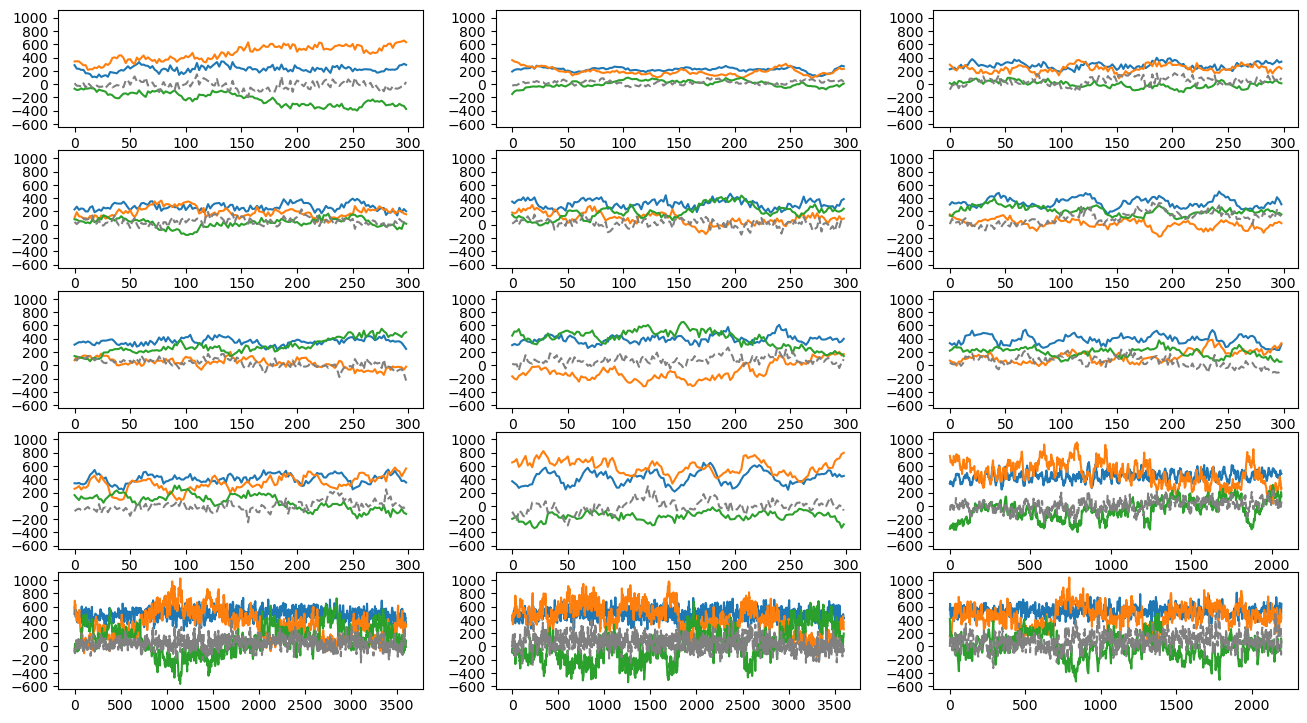

In [73]:
flowrate_folder = r"E:\AN\10172022\channel_flowrate_rb"
n = 13
fig = plt.figure(figsize=(16, 9), dpi=100)
for num, n in enumerate(range(4, 19)):
    data = pd.read_csv(os.path.join(flowrate_folder, "{:02d}.csv".format(n)))
    ax = fig.add_subplot(5, 3, num+1, sharey=ax)
    ax.plot(data.t, data["crop-0"], label="$A$")
    ax.plot(data.t, data["crop-1"], label="$B$")
    ax.plot(data.t, data["crop-2"], label="$C$")
    # ax.set_xlabel("$t$ (s)")
    # ax.set_ylabel("flow rate (px$^2$/s)")
    ax.plot(data.t, data["crop-0"] - data["crop-1"] - data["crop-2"], color="gray", ls="--", label="$A-B-C$")
    
    # ax.legend(frameon=False)

### 2.5 Normalize flow rate

In [74]:
flowrate_folder = r"E:\AN\10172022\channel_flowrate_rb"
flow_data = pd.read_csv(os.path.join(flowrate_folder_rb, "14.csv"))
flow_data.head()

,crop-0,crop-1,crop-2,t
0,370.817845,653.337855,-195.456327,0
1,343.999827,667.574907,-180.495546,2
2,317.374682,703.399163,-154.375359,4
3,270.075610,586.576472,-241.117395,6
4,291.124701,621.510550,-235.715612,8


In [75]:
norm = flow_data["crop-0"].mean()
norm_flow_data = flow_data.copy()
mean0 = norm_flow_data["crop-0"].mean()
norm_flow_data[["crop-0", "crop-1", "crop-2"]] /= mean0

Text(0, 0.5, 'flow rate (px$^2$/s)')

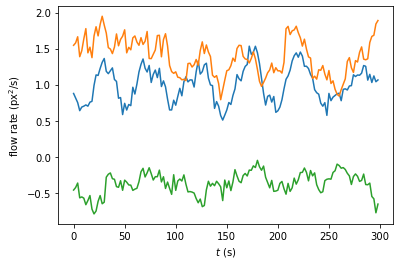

In [78]:
fig, ax = plt.subplots()
ax.plot(norm_flow_data.t, norm_flow_data["crop-0"])
ax.plot(norm_flow_data.t, norm_flow_data["crop-1"])
ax.plot(norm_flow_data.t, norm_flow_data["crop-2"])
ax.set_xlabel("$t$ (s)")
ax.set_ylabel("flow rate (px$^2$/s)")

### 3 Test preprocess - subtract background (in particular the dark concentric rings)

We notice that the images from the Gulliver confocal always have outstanding concentric dark rings, likely caused by the confocal spin unit (CSU). In the previous sections, we have analyzed the images without correcting these rings. Here, we compare the results from with/without correction, to see if a correction is necessary. If necessary, we will implement a python version of batch background subtration. 

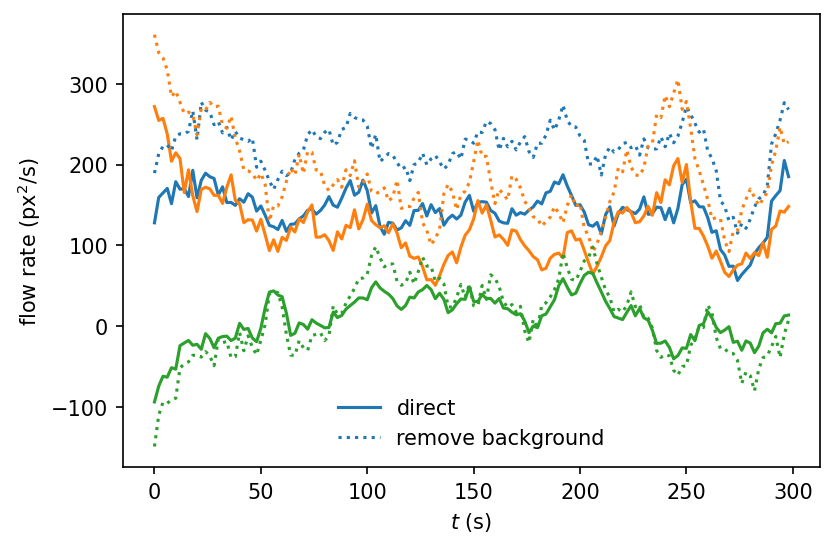

In [30]:
flowrate_folder = r"E:\AN\10172022\channel_flowrate"
flowrate_folder_rb = r"E:\AN\10172022\channel_flowrate_rb"
n = 5
# fig = plt.figure(figsize=(16, 9), dpi=100)
fig, ax = plt.subplots(dpi=150)
data = pd.read_csv(os.path.join(flowrate_folder, "{:02d}.csv".format(n)))
data_rb = pd.read_csv(os.path.join(flowrate_folder_rb, "{:02d}.csv".format(n)))
# ax = fig.add_subplot(5, 3, num+1)
ax.plot(data.t, data["crop-0"], label="direct", color=bestcolor(0))
ax.plot(data.t, data["crop-1"], color=bestcolor(1))
ax.plot(data.t, data["crop-2"], color=bestcolor(2))
ax.plot(data.t, data_rb["crop-0"], label="remove background", color=bestcolor(0), ls=":")
ax.plot(data.t, data_rb["crop-1"], color=bestcolor(1), ls=":")
ax.plot(data.t, data_rb["crop-2"], color=bestcolor(2), ls=":")
ax.set_xlabel("$t$ (s)")
ax.set_ylabel("flow rate (px$^2$/s)")
# ax.plot(data.t, data["crop-0"] - data["crop-1"] - data["crop-2"], color="gray", ls="--", label="$A-B-C$")

ax.legend(frameon=False)

The above comparison suggests that there is noticealbe difference between PIV on images with/without background subtraction. On images where background is subtracted, the measured velocity is generally larger than original images. This is expected because the dark rings in the images are stationary patterns, which make the detected motion slower. In the future, all the PIV should be done on images where background is subtracted. Here, we implement a code to batch process raw images. 

### 3.1 Implement background subtraction

- Median z-projection
- divide raw images by the projection

In [49]:
raw_folder = r"E:\AN\10172022\16\raw"
rb_folder = r"E:\AN\10172022\16\remove-background"
l = readdata(raw_folder, "tif")
imgs = []
for num, i in l.iterrows():
    img = io.imread(i.Dir)
    imgs.append(img)
stack = np.stack(imgs, axis=0) # TXY image stack

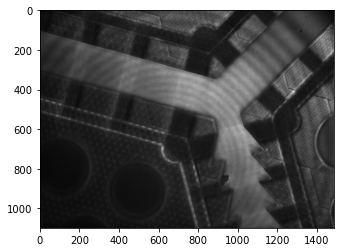

In [50]:
# median projection
med = np.median(stack, axis=0)
plt.imshow(med, cmap="gray")

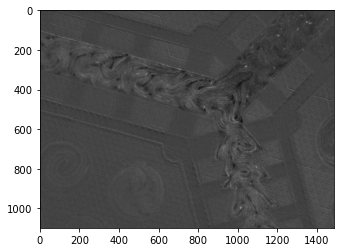

In [51]:
img = stack[0]
plt.imshow(img/med, cmap="gray")

In [52]:
subtract_stack = np.divide(stack, med)
img = subtract_stack[0]
plt.imshow(img, cmap="gray")

MemoryError: Unable to allocate 43.7 GiB for an array with shape (3601, 1098, 1484) and data type float64

Unable to do `np.divide` in the current configuration, because memory is not enough. 

In [64]:
imgr0 = stack[0] / med
low, high = imgr0.min(), imgr0.max()
for num, img in enumerate(stack):
    imgr = img / med
    img8 = ((imgr - low) / (high - low) * 255).astype(np.uint8)
    io.imsave(os.path.join(rb_folder, "{:05d}.tif".format(num)), img8)

**Batch remove background**

In [66]:
folder = r"E:\AN\10172022"
n = 4
for n in range(5, 19):
    raw_folder = r"E:\AN\10172022\{:02d}\raw".format(n)
    rb_folder = r"E:\AN\10172022\{:02d}\remove-background".format(n)
    if os.path.exists(rb_folder) == False:
        os.makedirs(rb_folder)
    else:
        continue
    l = readdata(raw_folder, "tif")
    imgs = []
    for num, i in l.iterrows():
        img = io.imread(i.Dir)
        imgs.append(img)
    stack = np.stack(imgs, axis=0) # TXY image stack

    med = np.median(stack, axis=0)

    imgr0 = stack[0] / med
    low, high = imgr0.min(), imgr0.max()
    for num, img in enumerate(stack):
        imgr = img / med
        img8 = ((imgr - low) / (high - low) * 255).astype(np.uint8)
        io.imsave(os.path.join(rb_folder, "{:05d}.tif".format(num)), img8)

## 4 Flow configuration probability

We plot the probability of flow configuration on a $\phi_B$-$\phi_C$ axis.

In [151]:
flowrate_folder = r"E:\AN\10172022\channel_flowrate_rb"
flow_data = pd.read_csv(os.path.join(flowrate_folder_rb, "15.csv"))
flow_data.head()

,crop-0,crop-1,crop-2,t
0,335.052069,750.809792,-344.309185,0
1,325.911494,728.188197,-347.093625,2
2,372.881582,680.941050,-300.550999,4
3,354.177440,652.154223,-306.787042,6
4,341.755490,684.950654,-296.860997,8


In [152]:
norm = flow_data["crop-0"].mean()
norm_flow_data = flow_data.copy()
mean0 = norm_flow_data["crop-0"].mean()
norm_flow_data[["crop-0", "crop-1", "crop-2"]] /= mean0

Text(0, 0.5, 'flow rate (px$^2$/s)')

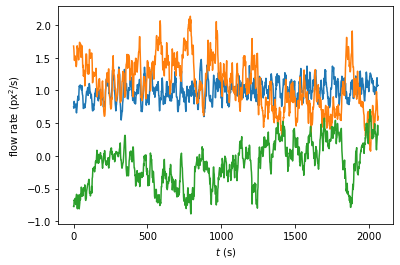

In [153]:
fig, ax = plt.subplots()
ax.plot(norm_flow_data.t, norm_flow_data["crop-0"])
ax.plot(norm_flow_data.t, norm_flow_data["crop-1"])
ax.plot(norm_flow_data.t, norm_flow_data["crop-2"])
ax.set_xlabel("$t$ (s)")
ax.set_ylabel("flow rate (px$^2$/s)")

In [154]:
H, xedges, yedges = np.histogram2d(norm_flow_data["crop-1"], norm_flow_data["crop-2"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])

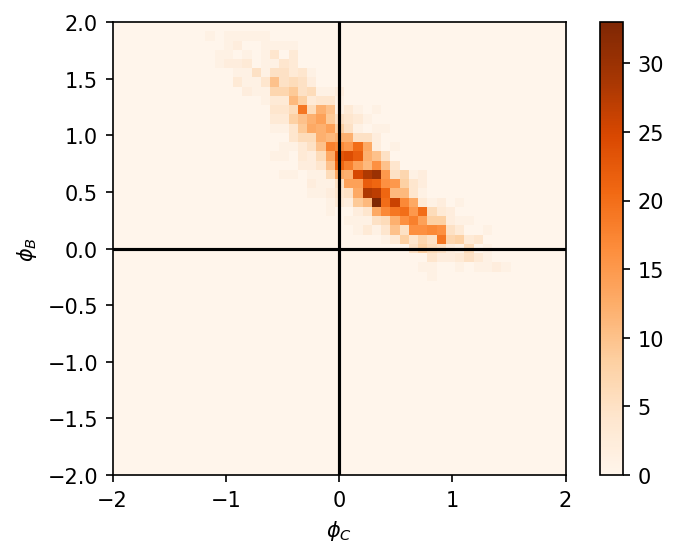

In [141]:
plt.figure(dpi=150)
plt.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.plot([-2, 2], [0, 0], color="black")
plt.plot([0, 0], [-2, 2], color="black")
plt.xlabel("$\phi_C$")
plt.ylabel("$\phi_B$")
plt.colorbar()

Text(0, 0.5, '$\\phi_B$')

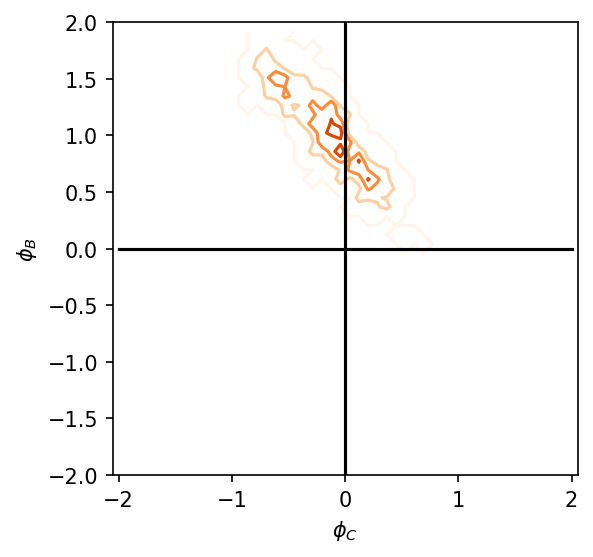

In [155]:
# Contour plot
plt.figure(figsize=(4, 4), dpi=150)
levels = np.linspace(np.min(H), np.max(H), 5)

plt.axis("equal")
plt.contour(xedges[:-1], yedges[:-1], H, levels=levels, cmap="Oranges")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.plot([-2, 2], [0, 0], color="black")
plt.plot([0, 0], [-2, 2], color="black")
# plt.colorbar()
plt.xlabel("$\phi_C$")
plt.ylabel("$\phi_B$")

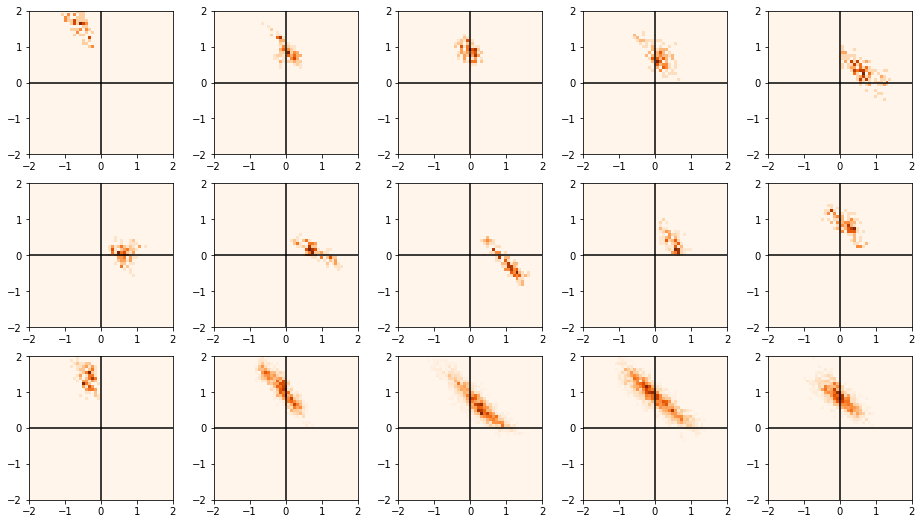

In [160]:
fig = plt.figure(figsize=(16, 9))
num = 1
flowrate_folder = r"E:\AN\10172022\channel_flowrate_rb"

for n in range(4, 19):
    ax = fig.add_subplot(3, 5, num)
    flow_data = pd.read_csv(os.path.join(flowrate_folder_rb, "{:02d}.csv".format(n)))
    norm = flow_data["crop-0"].mean()
    norm_flow_data = flow_data.copy()
    mean0 = norm_flow_data["crop-0"].mean()
    norm_flow_data[["crop-0", "crop-1", "crop-2"]] /= mean0
    H, xedges, yedges = np.histogram2d(norm_flow_data["crop-1"], norm_flow_data["crop-2"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
    ax.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
    ax.plot([-2, 2], [0, 0], color="black")
    ax.plot([0, 0], [-2, 2], color="black")
    num += 1